# Ball - Hand Detection
The Dataset on which I am evaluating the algorithms is thanks to ____ who labeled the balls through a color based & optical flow technique. !(Dataset Here)[ghghg] 

## Import

In [26]:
import numpy as np
import argparse
import cv2
import os
import random
import json
import csv
from moviepy.editor import VideoFileClip,VideoClip,ImageSequenceClip,concatenate_videoclips,TextClip
from moviepy.video import fx
# from moviepy.editor import *
# import moviepy.video.fx.all as vfx
from IPython.display import HTML, YouTubeVideo, display
import matplotlib.pyplot as plt
import shutil
%matplotlib inline

## Watch Input Video

In [4]:
video_name = "ss441_id_013.MP4"
video_path = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","Source_Video", video_name)

# Watch Video
display(HTML("""
            <video width="960" height="540" controls>
              <source src="{0}">
            </video>
            """.format(video_path)))

## General Info from Video

Frames Per Sec FPS = 30.0
Number of Frames   = 5940
Duration [Sec]     = 198
Duration [Min:Sec] = 3:18
Width:  480  Height: 848


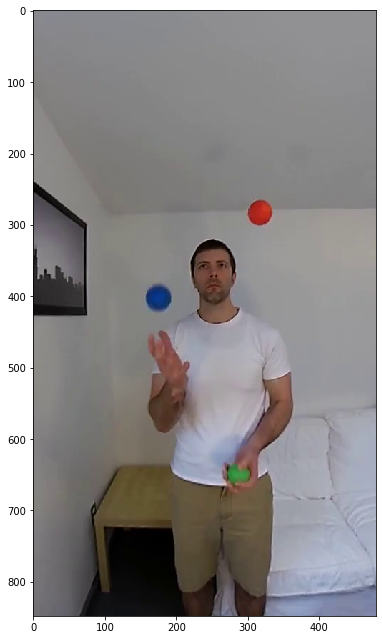

In [9]:
# Load video
cap = cv2.VideoCapture(video_path)

# Get General Info
fps         = cap.get(cv2.CAP_PROP_FPS)      # OpenCV2 version 2 used "CV_CAP_PROP_FPS"
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration    = int(frame_count/fps)
width       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))  # float
height      = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # float

# Read frame
frame_num = 0
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
_,frame=cap.read()

# Display
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
print('Frames Per Sec FPS = ' + str(fps))
print('Number of Frames   = ' + str(frame_count))
print('Duration [Sec]     = ' + str(duration))
minutes = int(duration/60)
seconds = duration%60
print('Duration [Min:Sec] = ' + str(minutes) + ':' + str(seconds))
print("Width: ", width, ' Height:', height)


## Hand Detection
#### Helper Functions

In [13]:
def draw_keyPts(img,key_list,color):
    """
    Draws on a color image the key_list given.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Key List
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            (x,y) = int(key_list[i]),int(key_list[i+1])
            cv2.circle(img_to_draw, (x,y), radius= 3, color=color, thickness=-1)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 1, 0) 
    return output_img

def draw_hand_boundaries(img,key_list,radius):
    """
    Draws on a color image the hand boundaries which are defined by circles of
    size radius to every circle center in the key_list given.    
    """
    # Create blank image: if not color yet then create "color" binary image
    if len(img.shape) == 2:         #if single channel
        img = np.dstack((img, img, img))
    img_to_draw = np.copy(img)*0
    
    # Draw Key List
    for i in range(0,len(key_list),3):
        if key_list[i+2] != 0: #If confidence score not zero
            (x,y) = int(key_list[i]),int(key_list[i+1])
            cv2.circle(img_to_draw, (x,y), radius= radius, color=[255, 255, 102], thickness=2)

    # Add keypoints to original img
    output_img = cv2.addWeighted(img_to_draw, 1, img, 1, 0) 
    return output_img



#### Read File and Define Keypoints of Interest(KoI)

In [21]:
# READ FILE
video_name_part = video_name.split(".")    # sample & mp4 has been split
#file_path = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","FullBody_Tracking_Data", video_name_part[0], video_name_part[0], ".json")
file_path = os.path.join("..","DATASET_Juggling","test_images","test.json")
with open(file_path) as f:
  data = json.load(f)

person      = 0
right_wrist = 4
left_wrist  = 7
body_keyPts        = data['people'][person]["pose_keypoints_2d"]
right_wrist_keyPts = body_keyPts[3*right_wrist : 3*right_wrist +3]
left_wrist_keyPts  = body_keyPts[3*left_wrist  : 3*left_wrist +3]
right_hand_keyPts  = data['people'][person]["hand_right_keypoints_2d"]
left_hand_keyPts   = data['people'][person]["hand_left_keypoints_2d"]


#### Draw KOI and Hand Boundaries

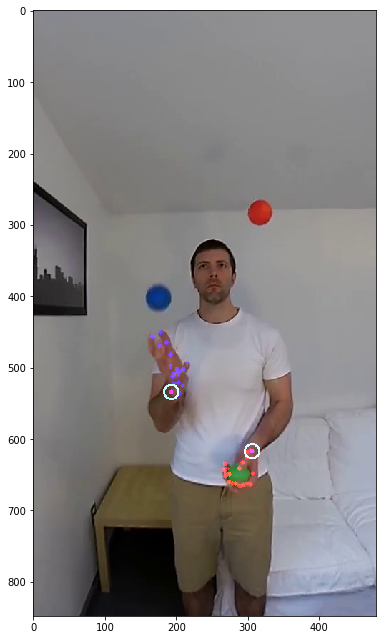

In [19]:
#Wrists
wrist_keyPts = np.hstack((right_wrist_keyPts, left_wrist_keyPts))
color = [255, 0, 255]
out_image = draw_keyPts(frame, wrist_keyPts, color)

#Hands
color = [255, 0, 0]
out_image = draw_keyPts(out_image, right_hand_keyPts,color)
color = [0, 0, 255]
out_image = draw_keyPts(out_image, left_hand_keyPts,color)

#Boundaries
radius = 10
hand_centroids = wrist_keyPts #FOR NOW LET's DEFINE IT THIS WAY!!!!!!!!
out_image = draw_hand_boundaries(out_image,hand_centroids,radius)

# Display 
f, ax = plt.subplots(1, 1, figsize=(24, 9))  # width and heights in inches
f.tight_layout()
ax.imshow(cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB))
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))  # width and heights in inches
# f.tight_layout()
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
# ax1.set_title('Original Image', fontsize=50)
# ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
# ax2.set_title('KOI Image', fontsize=50)
# ax2.imshow(cv2.cvtColor(out_image, cv2.COLOR_BGR2RGB))


## Ball Detection

In [29]:
# READ CSV File
balls_loc = []
file_path = os.path.join("..","DATASET_Juggling","Juggling_Pattern_Dataset","Ball_Tracking_Data", video_name_part[0] + ".csv")
with open(file_path) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        balls_loc.append(line)
